## Script de création de graphe
cf base de donnée CAIDA : https://publicdata.caida.org/datasets/as-relationships/serial-2/


**README :**
 
The as-rel files contain p2p and p2c relationships.
The format is:

`<provider-as>|<customer-as>|-1` <br>
`<peer-as>|<peer-as>|0|<source>`

    
Example : 
    
`1|11537|0|bgp` <br>
`1|21616|-1|bgp`

Le fichier contient environ 100 000 lignes de ce type

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os
import pandas as pd
import networkx as nx
import pickle
os.popen("export DGLBACKEND=pytorch")
import dgl as dgl
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import arange

Using backend: pytorch


#### Définition diverses de fonction (utilisant du bash) permettant de vérifier que le graphe a été bien créé

In [2]:
# Fichier au choix parmi ceux de ./data/CAIDA_AS_RELATIONSHIP
FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20200101.as-rel2.txt'

In [3]:
def encadre(message):
    print("\n****************************")
    print(message)
    print("****************************\n")

def nb_node_of_AS(file):
    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read()
    
def nb_edge_of_AS(file):
    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read()

def list_nodes_sorted(file):
    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq" %file).read()

def nb_peering_customer_provider(ASN):
    nb_peerings =  os.popen("cat %s | grep \"^%s|\||%s|\" | grep -v \".*\-1\" | wc -l" % (FILE_PATH, ASN, ASN)).read()
    nb_customers = os.popen("cat %s | grep \"^%s|.*\-1\" |wc -l " % (FILE_PATH, ASN)).read()
    nb_providers = os.popen("cat %s | grep \"|%s|\-1\" | wc -l" % (FILE_PATH, ASN)).read()
    return nb_peerings.split("\n")[0], nb_customers.split("\n")[0], nb_providers.split("\n")[0]

def csv_dataset(file):
    return os.popen()

In [4]:
nb_type_links = nb_peering_customer_provider(4)
print("Link types and number (p2p, c, p) of node index 4 : " + str(nb_type_links))

Link types and number (p2p, c, p) of node index 4 : ('3', '3', '10')


### Panda Datasets

In [5]:
AS_dataset_202001 = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20200101.as2types.txt', sep='|')

### ATTENTION : si erruer, lancer le script `./sort_datasets.sh -h`

In [6]:
AS_dataset_202001.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67308 entries, 0 to 67307
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ASN           67308 non-null  int64 
 1   source_label  67308 non-null  object
 2   label         67308 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [7]:
print(AS_dataset_202001["label"].value_counts())
print("\n")
print(AS_dataset_202001["source_label"].value_counts())

Transit/Access    44745
Enterprise        18365
Content            4198
Name: label, dtype: int64


CAIDA_class     55755
peerDB_class    10880
manual_class      673
Name: source_label, dtype: int64


<AxesSubplot:>

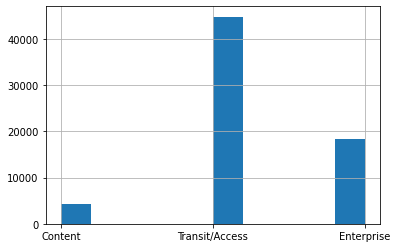

In [8]:
AS_dataset_202001["label"].hist()

In [9]:
AS_dataset_202001.head()

,ASN,source_label,label
0,1,CAIDA_class,Content
1,2,CAIDA_class,Transit/Access
2,3,CAIDA_class,Transit/Access
3,4,CAIDA_class,Transit/Access
4,5,CAIDA_class,Transit/Access


In [10]:
def dictiongraph(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(sorted(list(set(dictio))), l))
    return dictiofinal

In [11]:
def creation_graph(fichier_texte):
    G = nx.Graph() 
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= str(asn1) + '|p2p|' +str(asn2))
            elif info == -1 :

                G.add_edge(dictio[asn1],dictio[asn2],type=str(asn1) + '|p2c|' +str(asn2))
        except ValueError:
            pass
    return G

In [12]:
G = creation_graph(FILE_PATH)

In [13]:
def creation_graph_float(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 1/3)
        except ValueError:
            pass
    return G

In [14]:
G_float =creation_graph_float(FILE_PATH)

In [15]:
def creation_graph_array(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= np.array([0,1,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type= np.array([0,1,0]))
            elif info == -1 :

                G.add_edge(dictio[asn1],dictio[asn2],type=np.array([1,0,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type=np.array([0,0,1]))
        except ValueError:
            pass
    return G

In [16]:
G_array =creation_graph_array(FILE_PATH)

In [17]:
nb_nodes_graph = G.number_of_nodes()
nb_edges_graph = G.number_of_edges()

print("Nb nodes du graphe : " + str(nb_nodes_graph))
print("Nb edges du graphe: " + str(nb_edges_graph))

assert(nb_nodes_graph == int(nb_node_of_AS(FILE_PATH)))
print("\nASSERT NB NODES OK")

Nb nodes du graphe : 67308
Nb edges du graphe: 446633

ASSERT NB NODES OK


In [18]:
list_pageRank = nx.pagerank(G).values()
list_degreeCentrality = nx.degree_centrality(G).values()

- ### Ajout des colonnes `page_rank` et `degree_centrality`

In [19]:
AS_dataset_202001['page_rank'] = list_pageRank
AS_dataset_202001['degree_centrality'] = list_degreeCentrality

In [20]:
AS_dataset_202001.head()

,ASN,source_label,label,page_rank,degree_centrality
0,1,CAIDA_class,Content,0.000025,0.000193
1,2,CAIDA_class,Transit/Access,0.000064,0.000490
2,3,CAIDA_class,Transit/Access,0.000037,0.000342
3,4,CAIDA_class,Transit/Access,0.000034,0.000238
4,5,CAIDA_class,Transit/Access,0.000018,0.000134


In [21]:
AS_dataset_202001.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67308 entries, 0 to 67307
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ASN                67308 non-null  int64  
 1   source_label       67308 non-null  object 
 2   label              67308 non-null  object 
 3   page_rank          67308 non-null  float64
 4   degree_centrality  67308 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.6+ MB


In [22]:
def dictiongraph_Nbnoeud_Asn(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(l, sorted(list(set(dictio)))))
    return dictiofinal
Dictio_noeud_as = dictiongraph_Nbnoeud_Asn(FILE_PATH)

In [23]:
def nbtypevoisins2(G):
    nbNoeuds = G.number_of_nodes()
    Liste_Nb_Voisins_Peering = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Customer = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Provider = np.zeros(nbNoeuds)
    for i in range(nbNoeuds):
        for j in range(len(G[i])) :
            infos = list(G[i].values())[j]["type"].split("|")
            #print(infos)
            type_lien = infos[1]
            if type_lien == "p2p":

                Liste_Nb_Voisins_Peering[i] +=1
                #Liste_Nb_Voisins_Peering[dictio_as_noeud[int(asn2)]] +=1
            elif type_lien == "p2c":
                asn1 = infos[0]
                asn2 = infos[2]
                if int(asn2) == int(Dictio_noeud_as[i]) :
                     Liste_Nb_Voisins_Provider[i]+=1                
                else :
                    Liste_Nb_Voisins_Customer[i]+=1

        #print(i)

    return Liste_Nb_Voisins_Peering, Liste_Nb_Voisins_Customer, Liste_Nb_Voisins_Provider 
                
#### TEMPS D'EXECUTION : 5min ~
L1,L2,L3=nbtypevoisins2(G) 

- ### Vérification de la conformité des listes L1, L2 et L3 par rapport au graphe

In [24]:
max_degree_list = max(L1 + L2 + L3)
highest_degree_graph = max(list(dict(G.degree()).values()))
index_max = list(dict(G.degree()).values()).index(highest_degree_graph)
ASN_max = list(Dictio_noeud_as.values())[index_max]

print("Max degree list : " + str(max_degree_list))
print("Max degree index : " + str(index_max) + ", max degree ASN : " + str(ASN_max))
print("Max degree graph : " + str(highest_degree_graph))

assert (max_degree_list == highest_degree_graph)
print("\nASSERT MAX DEGREE OK")

Max degree list : 8161.0
Max degree index : 2508, max degree ASN : 6939
Max degree graph : 8161

ASSERT MAX DEGREE OK


In [25]:
# Extraction des maximum de p2p link, customer link et provider link
max_p2p, index_max_p2p = np.max(L1), np.argmax(L1)
max_c,   index_max_c   = np.max(L2), np.argmax(L2)
max_p,   index_max_p   = np.max(L3), np.argmax(L3)

print("Max p2p links     : "      + str(max_p2p) + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_p2p]))
print("Max nb customer links  : " + str(max_c)   + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_c]))
print("Max nb provider links :  " + str(max_p)   + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_p]))

Max p2p links     : 6658.0, ASN : 6939
Max nb customer links  : 5959.0, ASN : 174
Max nb provider links :  120.0, ASN : 20940


- ### Ajout des colonnes `peering_links`, `customer_links` et `provider_links`

In [26]:
AS_dataset_202001['peering_links'] = L1/max_p2p
AS_dataset_202001['customer_links'] = L2/max_c
AS_dataset_202001['provider_links'] = L3/max_p

assert(AS_dataset_202001['peering_links'][index_max_p2p] == 1)
assert(AS_dataset_202001['customer_links'][index_max_c] == 1)
assert(AS_dataset_202001['provider_links'][index_max_p] == 1)

In [27]:
AS_dataset_202001.head()

,ASN,source_label,label,page_rank,degree_centrality,peering_links,customer_links,provider_links
0,1,CAIDA_class,Content,0.000025,0.000193,0.000150,0.000000,0.100000
1,2,CAIDA_class,Transit/Access,0.000064,0.000490,0.001202,0.001007,0.158333
2,3,CAIDA_class,Transit/Access,0.000037,0.000342,0.000451,0.000671,0.133333
3,4,CAIDA_class,Transit/Access,0.000034,0.000238,0.000451,0.000503,0.083333
4,5,CAIDA_class,Transit/Access,0.000018,0.000134,0.000150,0.000168,0.058333


- ### Ajout des colonnes `is_Content`, `is_Transit/Access` et `is_Enterprise`

En effet, la colonne `label` est une **catégorie non ordinale**. Il faut donc la transformer en vecteur de valeur binaire, qui sera donné au GCN. <br> **On a alors :** <br><br>
dataset['is_Content'][i] = 1 ⇔ le noeud i du graphe est de type `Content` <br>
dataset['is_Transit/Access'][i] = 1 ⇔ le noeud i du graphe est de type `Transit/Access` <br>
dataset['is_Enterprise'][i] = 1 ⇔ le noeud i du graphe est de type `Enterprise` <br>

In [28]:
AS_dataset_202001['is_Content'] = (AS_dataset_202001['label'] == 'Content').astype(int)
AS_dataset_202001['is_Transit/Access'] = (AS_dataset_202001['label'] == 'Transit/Access').astype(int)
AS_dataset_202001['is_Enterprise'] = (AS_dataset_202001['label'] == 'Enterprise').astype(int)

In [29]:
AS_dataset_202001.head()

,ASN,source_label,label,page_rank,degree_centrality,peering_links,customer_links,provider_links,is_Content,is_Transit/Access,is_Enterprise
0,1,CAIDA_class,Content,0.000025,0.000193,0.000150,0.000000,0.100000,1,0,0
1,2,CAIDA_class,Transit/Access,0.000064,0.000490,0.001202,0.001007,0.158333,0,1,0
2,3,CAIDA_class,Transit/Access,0.000037,0.000342,0.000451,0.000671,0.133333,0,1,0
3,4,CAIDA_class,Transit/Access,0.000034,0.000238,0.000451,0.000503,0.083333,0,1,0
4,5,CAIDA_class,Transit/Access,0.000018,0.000134,0.000150,0.000168,0.058333,0,1,0


- ### Modification de la colonne `label`

On transforme la **catégorie non ordinale** en 3 classes entières :
 - *Content* ⇔ $0$
 - *Transit/Access* ⇔ $1$
 - *Enterprise* ⇔ $2$

In [39]:
AS_dataset_202001['label'] = AS_dataset_202001['label'].map({'Content': 0, 'Transit/Access': 1, 'Enterprise': 2})

In [40]:
AS_dataset_202001.head()

,ASN,source_label,label,page_rank,degree_centrality,peering_links,customer_links,provider_links,is_Content,is_Transit/Access,is_Enterprise
0,1,CAIDA_class,0,0.000025,0.000193,0.000150,0.000000,0.100000,1,0,0
1,2,CAIDA_class,1,0.000064,0.000490,0.001202,0.001007,0.158333,0,1,0
2,3,CAIDA_class,1,0.000037,0.000342,0.000451,0.000671,0.133333,0,1,0
3,4,CAIDA_class,1,0.000034,0.000238,0.000451,0.000503,0.083333,0,1,0
4,5,CAIDA_class,1,0.000018,0.000134,0.000150,0.000168,0.058333,0,1,0


### Exportation des données : `dataset` et `graph`

On crée 4 fichiers : 
- Le `dataset`complet 
- Le `graphe` nx au format pickle
- Le `graphe_float` nx au format pickle
- Le `graphe_array` nx au format pickle

In [42]:
# Exportation des données

AS_dataset_202001.to_csv('data_GCN/dataset_202001.csv', index=False)
nx.write_gpickle(G, 'data_GCN/graph_202001.pickle')
nx.write_gpickle(G_float, 'data_GCN/graph_float_202001.pickle')
nx.write_gpickle(G_array, 'data_GCN/graph_array_202001.pickle')

In [31]:
G_float[5]

AtlasView({1209: {'type': 0.3333333333333333}, 2276: {'type': 0.3333333333333333}, 8075: {'type': 0.3333333333333333}, 12607: {'type': 0.3333333333333333}})

In [38]:
G_dgl_float = dgl.from_networkx(G_float, edge_attrs=['type'])